In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
class RiverData:
    def __init__(self, file_path, river_name):
        self.file_path = file_path
        self.river_name = river_name
        self.data = self._load_workbook()
    
    def _load_workbook(self):
        excel_data = pd.ExcelFile(self.file_path)
        data = {}
        for sheet_name in excel_data.sheet_names:
            reach_number = int(sheet_name.split('_')[-1])
            df = pd.read_excel(excel_data, sheet_name=sheet_name)
            df.rename(columns={df.columns[0]: 'Year'}, inplace=True)
            data[reach_number] = df
        return data
    
    def get_data_by_year_reach(self, year, reach):
        if reach in self.data:
            df = self.data[reach]
            return df[df['Year'] == year]
        else:
            return f"Reach {reach} not found."
    
    def get_metric_by_year_reach(self, year, reach, metric):
        if reach in self.data:
            df = self.data[reach]
            if metric in df.columns:
                return df[df['Year'] == year][metric].values
            else:
                return f"Metric {metric} not found."
        else:
            return f"Reach {reach} not found."
    
    def get_summary_by_reach(self, reach):
        if reach in self.data:
            return self.data[reach]
        else:
            return f"Reach {reach} not found."
    
    def _filter_data(self, year_range, reach_range):
        filtered_data = []
        for reach, df in self.data.items():
            if reach_range == "All" or (reach_range[0] <= reach <= reach_range[1]):
                if year_range == "All":
                    filtered_data.append(df)
                else:
                    filtered_data.append(df[(df['Year'] >= year_range[0]) & (df['Year'] <= year_range[1])])
        return pd.concat(filtered_data) if filtered_data else pd.DataFrame()
    
    def calculate_metric_data(self, metric, year_range="All", reach_range="All"):
        """Calculate and return the filtered metric data."""
        data = self._filter_data(year_range, reach_range)
        if metric in data.columns:
            return data[metric].dropna().values
        else:
            return np.array([])
    
    def get_metric_over_time(self, reach, metric):
        """Retrieve and interpolate a specific metric over time for a given reach."""
        if reach in self.data:
            df = self.data[reach]
            if metric in df.columns:
                return df.set_index('Year')[metric].interpolate()
            else:
                return f"Metric {metric} not found."
        else:
            return f"Reach {reach} not found."

class RiverSystem:
    def __init__(self):
        self.rivers = {}
    
    def load_river(self, file_path, river_name):
        """Load a new river into the system."""
        self.rivers[river_name] = RiverData(file_path, river_name)
    
    def get_river(self, river_name):
        """Retrieve a RiverData object by name."""
        return self.rivers.get(river_name, f"River {river_name} not found.")
    
    def compare_metrics(self, metrics, year_range="All", reach_range="All", save_path=None):
        """Compare multiple metrics across all rivers with subplots."""
        
        n_metrics = len(metrics)
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 5 * n_metrics), sharex=False)
        
        color_cycle = plt.cm.tab10.colors  # Use a default color map (e.g., tab10)
        
        for i, metric in enumerate(metrics):
            color_index = 0
            ax = axes[i]
            
            metric_min, metric_max = np.inf, -np.inf  # Initialize min and max
            
            for river_name, river_data in self.rivers.items():
                metric_data = river_data.calculate_metric_data(metric, year_range, reach_range)
                if metric_data.size > 0:
                    # Perform KDE and plot the smooth curve
                    kde = gaussian_kde(metric_data)
                    x_range = np.linspace(metric_data.min(), metric_data.max(), 1000)
                    kde_values = kde(x_range)
                    
                    color = color_cycle[color_index % len(color_cycle)]  # Get the next color in the cycle
                    ax.plot(x_range, kde_values, label=river_name, color=color, linewidth=2)
                    
                    # Calculate and plot the median line (solid line)
                    median_value = np.median(metric_data)
                    ax.axvline(median_value, color=color, linestyle='-')  # Solid median line
                    
                    # Update metric_min and metric_max based on current data
                    metric_min = min(metric_min, metric_data.min())
                    metric_max = max(metric_max, metric_data.max())
                    
                    color_index += 1
            
            if metric == 'Sinuosity':
                ax.set_xlim(1, 2)  # Static x-axis range for Sinuosity
                ax.axvline(1.4, color='black', linestyle='--')
                ax.text(1.15, ax.get_ylim()[1] * 0.9, 'Low Sinuosity', ha='right', va='center', color='black', fontsize=10, fontweight='bold')
                ax.text(1.5, ax.get_ylim()[1] * 0.9, 'High Sinuosity', ha='left', va='center', color='black', fontsize=10, fontweight='bold')
            elif metric == 'CCI':
                ax.set_xscale('log')  # Logarithmic x-axis for CCI
                ax.set_xlim(1, 20)  # Static range from 1 to 20 for CCI
                
                # Set custom tick marks for the logarithmic scale
                ax.set_xticks([1, 1.4, 2, 3.5, 5, 10, 20])
                ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Ensure labels are in standard format
                
                ax.axvline(1.4, color='black', linestyle='--')
                ax.axvline(3.5, color='black', linestyle='--')
                ax.text(1.3, ax.get_ylim()[1] * 0.9, 'Single', ha='right', va='center', color='black', fontsize=10, fontweight='bold')
                ax.text(2.25, ax.get_ylim()[1] * 0.9, 'Wandering', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
                ax.text(5, ax.get_ylim()[1] * 0.9, 'Multithread', ha='left', va='center', color='black', fontsize=10, fontweight='bold')
            else:
                ax.set_xlim(metric_min, metric_max)  # Set the x-axis limits to the metric's range
            
            ax.set_title(f'Comparison of {metric} Across Rivers')
            ax.set_ylabel('Density')
            ax.grid(True)
            ax.legend(loc='upper right')  # Add a legend to each subplot
            
            if i == len(metrics) - 1:
                ax.set_xlabel('Value')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
            print(f"Comparison plot saved to {save_path}")
        
        plt.show()
        
    def compare_metrics_violin(self, metrics, year_range="All", reach_range="All", save_path=None):
        """Compare multiple metrics across all rivers using violin plots with subplots."""
        
        n_metrics = len(metrics)
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 5 * n_metrics), sharex=False)
        
        for i, metric in enumerate(metrics):
            ax = axes[i]
            
            # Prepare data for seaborn violin plot
            combined_data = []
            river_labels = []
            
            for river_name, river_data in self.rivers.items():
                metric_data = river_data.calculate_metric_data(metric, year_range, reach_range)
                if metric_data.size > 0:
                    combined_data.append(metric_data)
                    river_labels.extend([river_name] * len(metric_data))
            
            # Flatten combined_data and ensure it's a single array
            combined_data = np.concatenate(combined_data)
            
            if len(combined_data) > 0:
                # Create a DataFrame for easier handling by seaborn
                df = pd.DataFrame({
                    'Metric': combined_data,
                    'River': river_labels
                })

                # Plot violin plot
                sns.violinplot(x='Metric', y='River', data=df, ax=ax, cut=0, scale='width', inner='quartile')
                
                # Customizing axes and adding title
                ax.set_title(f'Violin Plot of {metric} Across Rivers')
                ax.set_xlabel(f'{metric} Value')
                ax.set_ylabel('River')
                ax.grid(True)
            
            # Special handling for specific metrics (Sinuosity, CCI)
            if metric == 'Sinuosity':
                ax.set_xlim(1, 2)  # Static x-axis range for Sinuosity
                ax.axvline(1.4, color='black', linestyle='--')
                ax.text(1.15, ax.get_ylim()[1] * 0.9, 'Low Sinuosity', ha='right', va='center', color='black', fontsize=10, fontweight='bold')
                ax.text(1.5, ax.get_ylim()[1] * 0.9, 'High Sinuosity', ha='left', va='center', color='black', fontsize=10, fontweight='bold')
            elif metric == 'CCI':
                ax.set_xscale('log')  # Logarithmic x-axis for CCI
                ax.set_xlim(1, 20)  # Static range from 1 to 20 for CCI
                
                # Set custom tick marks for the logarithmic scale
                ax.set_xticks([1, 1.4, 2, 3.5, 5, 10, 20])
                ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Ensure labels are in standard format
                
                ax.axvline(1.4, color='black', linestyle='--')
                ax.axvline(3.5, color='black', linestyle='--')
                ax.text(1.3, ax.get_ylim()[1] * 0.9, 'Single', ha='right', va='center', color='black', fontsize=10, fontweight='bold')
                ax.text(2.25, ax.get_ylim()[1] * 0.9, 'Wandering', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
                ax.text(5, ax.get_ylim()[1] * 0.9, 'Multithread', ha='left', va='center', color='black', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
            print(f"Violin plot comparison saved to {save_path}")
        
        plt.show()
    
    def compare_two_systems_mean_dots(self, other_system, metrics, system1_name="System 1", system2_name="System 2", year_range="All", reach_range="All", save_path=None):
        """
        Compare metrics across two different river systems using scatter plots of temporal mean values per reach.
        Instead of individual year/reach data points, this function calculates and plots the temporal mean of each reach.
        """
    
        n_metrics = len(metrics)
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 5 * n_metrics), sharex=False)
    
        for i, metric in enumerate(metrics):
            ax = axes[i]
        
            # Prepare data for plotting temporal means
            combined_data = []
            river_labels = []
            system_labels = []
        
            # First system's data: calculate temporal mean for each reach
            for river_name, river_data in self.rivers.items():
                reach_means = []
                for reach, df in river_data.data.items():
                    # Calculate mean of the metric over all years for the reach
                    if metric in df.columns:
                        mean_value = df[metric].mean()
                        reach_means.append(mean_value)
            
                if reach_means:
                    combined_data.extend(reach_means)
                    river_labels.extend([river_name] * len(reach_means))
                    system_labels.extend([system1_name] * len(reach_means))
        
            # Second system's data: calculate temporal mean for each reach
            for river_name, river_data in other_system.rivers.items():
                reach_means = []
                for reach, df in river_data.data.items():
                    # Calculate mean of the metric over all years for the reach
                    if metric in df.columns:
                        mean_value = df[metric].mean()
                        reach_means.append(mean_value)
            
                if reach_means:
                    combined_data.extend(reach_means)
                    river_labels.extend([river_name] * len(reach_means))
                    system_labels.extend([system2_name] * len(reach_means))
        
            # Create a DataFrame for easier handling by seaborn
            df = pd.DataFrame({
                'Metric': combined_data,
                'River': river_labels,
                'System': system_labels
            })
        
            # Plot scatter plot of temporal means
            sns.scatterplot(x='Metric', y='River', hue='System', data=df, ax=ax, s=100)
        
            # Customizing axes and adding title
            ax.set_title(f'Temporal Mean of {metric} Across {system1_name} and {system2_name}')
            ax.set_xlabel(f'Mean {metric} Value')
            ax.set_ylabel('River')
            ax.grid(True)
        
            # Adjust x-axis to fit the data range
            metric_min, metric_max = df['Metric'].min(), df['Metric'].max()
            ax.set_xlim(metric_min, metric_max)
    
        plt.tight_layout()
    
        if save_path:
            plt.savefig(save_path)
            print(f"Scatter plot of temporal means saved to {save_path}")
    
        plt.show()
        
    def compare_two_systems_mean_violin(self, other_system, metrics, system1_name="System 1", system2_name="System 2", year_range="All", reach_range="All", save_path=None):
        """
        Compare metrics across two different river systems using violin plots of temporal mean values per reach.
        Instead of individual year/reach data points, this function calculates and plots the temporal mean of each reach.
        """
    
        n_metrics = len(metrics)
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 5 * n_metrics), sharex=False)
    
        for i, metric in enumerate(metrics):
            ax = axes[i]
        
            # Prepare data for plotting temporal means
            combined_data = []
            river_labels = []
            system_labels = []
        
            # First system's data: calculate temporal mean for each reach
            for river_name, river_data in self.rivers.items():
                reach_means = []
                for reach, df in river_data.data.items():
                    # Calculate mean of the metric over all years for the reach
                    if metric in df.columns:
                        mean_value = df[metric].mean()
                        reach_means.append(mean_value)
            
                if reach_means:
                    combined_data.extend(reach_means)
                    river_labels.extend([river_name] * len(reach_means))
                    system_labels.extend([system1_name] * len(reach_means))
        
            # Second system's data: calculate temporal mean for each reach
            for river_name, river_data in other_system.rivers.items():
                reach_means = []
                for reach, df in river_data.data.items():
                    # Calculate mean of the metric over all years for the reach
                    if metric in df.columns:
                        mean_value = df[metric].mean()
                        reach_means.append(mean_value)
            
                if reach_means:
                    combined_data.extend(reach_means)
                    river_labels.extend([river_name] * len(reach_means))
                    system_labels.extend([system2_name] * len(reach_means))
        
            # Create a DataFrame for easier handling by seaborn
            df = pd.DataFrame({
                'Metric': combined_data,
                'River': river_labels,
                'System': system_labels
            })
        
            # Plot violin plot of temporal means
            sns.violinplot(x='Metric', y='River', hue='System', data=df, ax=ax, cut=0, scale='width', inner='quartile', split=True)
        
            # Customizing axes and adding title
            ax.set_title(f'Violin Plot of Temporal Mean {metric} Across {system1_name} and {system2_name}')
            ax.set_xlabel(f'Mean {metric} Value')
            ax.set_ylabel('River')
            ax.grid(True)
        
            # Adjust x-axis to fit the data range
            metric_min, metric_max = df['Metric'].min(), df['Metric'].max()
            ax.set_xlim(metric_min, metric_max)
    
        plt.tight_layout()
    
        if save_path:
            plt.savefig(save_path)
            print(f"Violin plot of temporal means saved to {save_path}")
    
        plt.show()
        
    def plot_metric_over_time_by_reach(self, metric, save_path='metric_over_time_by_reach.pdf'):
        """Plot a specified metric over time by reach for each river and save to a PDF."""
        
        with PdfPages(save_path) as pdf:
            for river_name, river_data in self.rivers.items():
                n_reaches = len(river_data.data)
                fig, axes = plt.subplots(n_reaches, 1, figsize=(10, 4 * n_reaches), sharex=True)
                
                if n_reaches == 1:
                    axes = [axes]  # Ensure axes is iterable even for a single subplot
                
                for i, (reach, df) in enumerate(sorted(river_data.data.items())):
                    ax = axes[i]
                    metric_series = river_data.get_metric_over_time(reach, metric)
                    
                    ax.plot(metric_series.index, metric_series.values, marker='o', linestyle='-', label=f'Reach {reach}')
                    ax.set_title(f'{river_name} - Reach {reach}')
                    ax.set_ylabel(metric)
                    ax.grid(True)
                    
                    # Set x-axis ticks and labels every 5 years from 1990 to 2020
                    years = range(1990, 2025, 5)
                    ax.set_xticks(years)
                    ax.set_xlim(1990, 2020)
                    ax.set_xticklabels([str(year) for year in years], rotation=45, ha='right')
                
                plt.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)
        
        print(f"PDF saved as {save_path}")

Comparison plot saved to C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalaya_distribution.jpeg


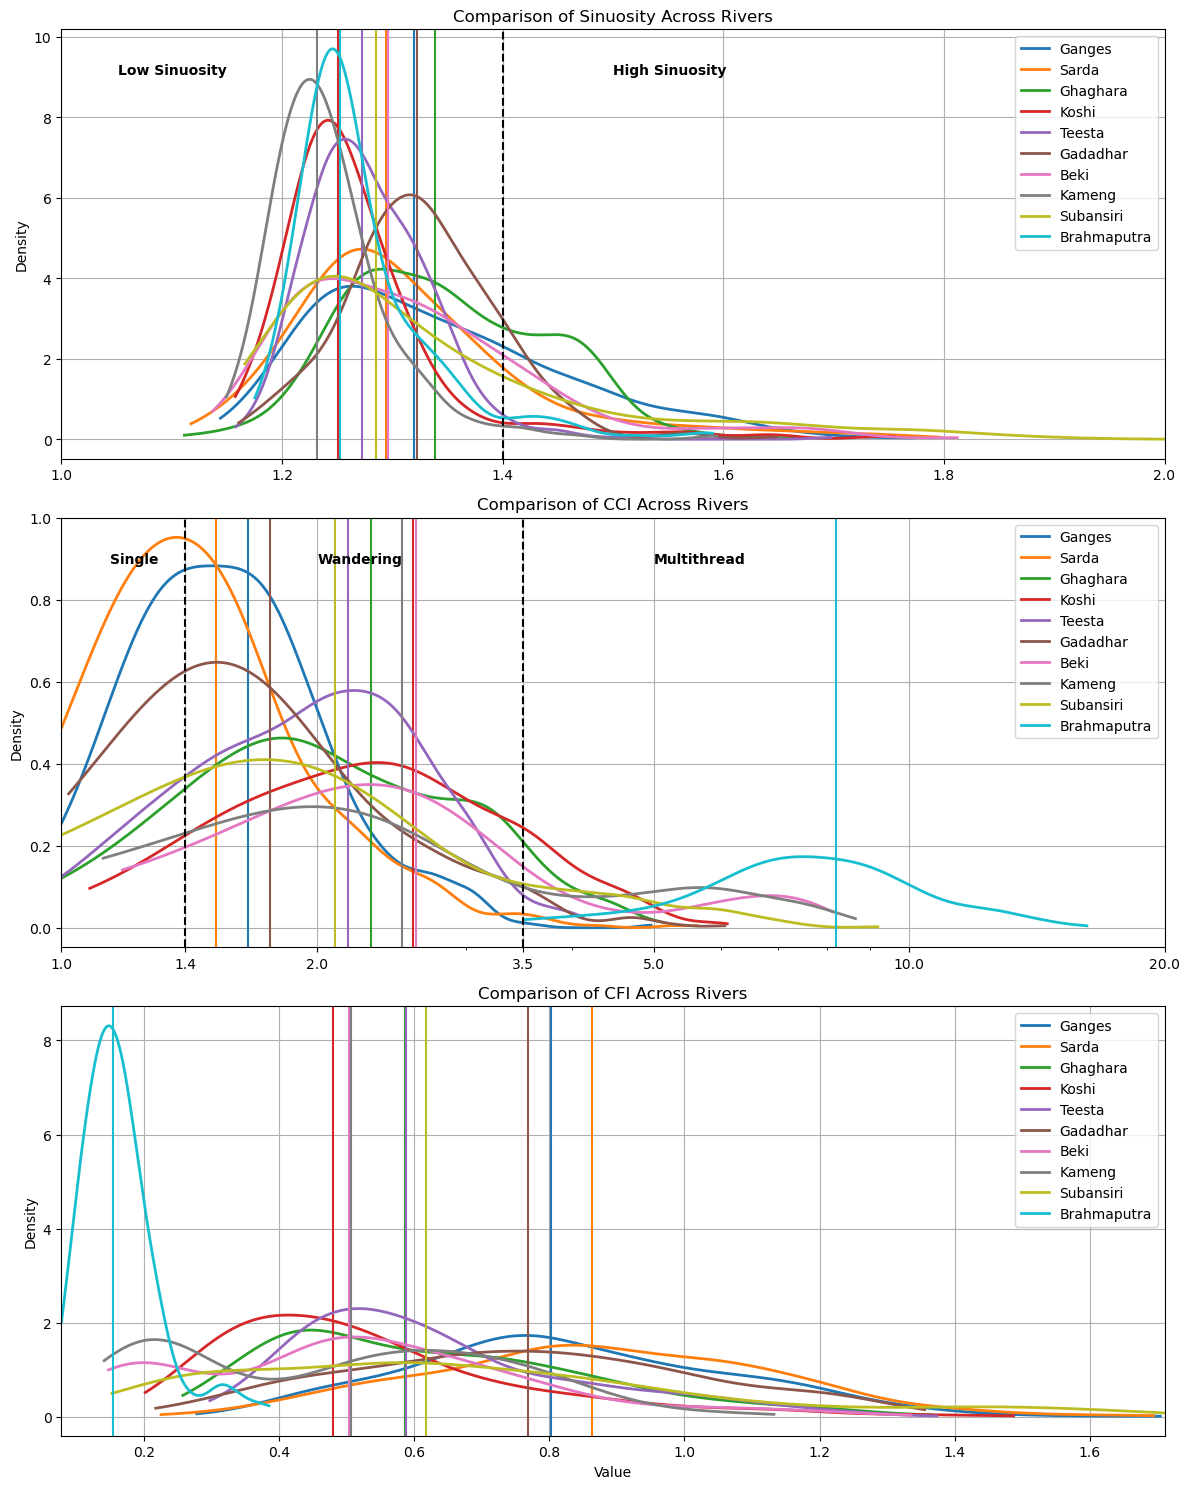

C:\Users\huckr\AppData\Local\Temp\ipykernel_9964\3972257554.py:183: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Metric', y='River', data=df, ax=ax, cut=0, scale='width', inner='quartile')
C:\Users\huckr\miniconda3\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\huckr\miniconda3\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\huckr\miniconda3\Lib\site-packages\seaborn\_base.py:949: FutureWarning

Violin plot comparison saved to C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalaya_violin.jpeg


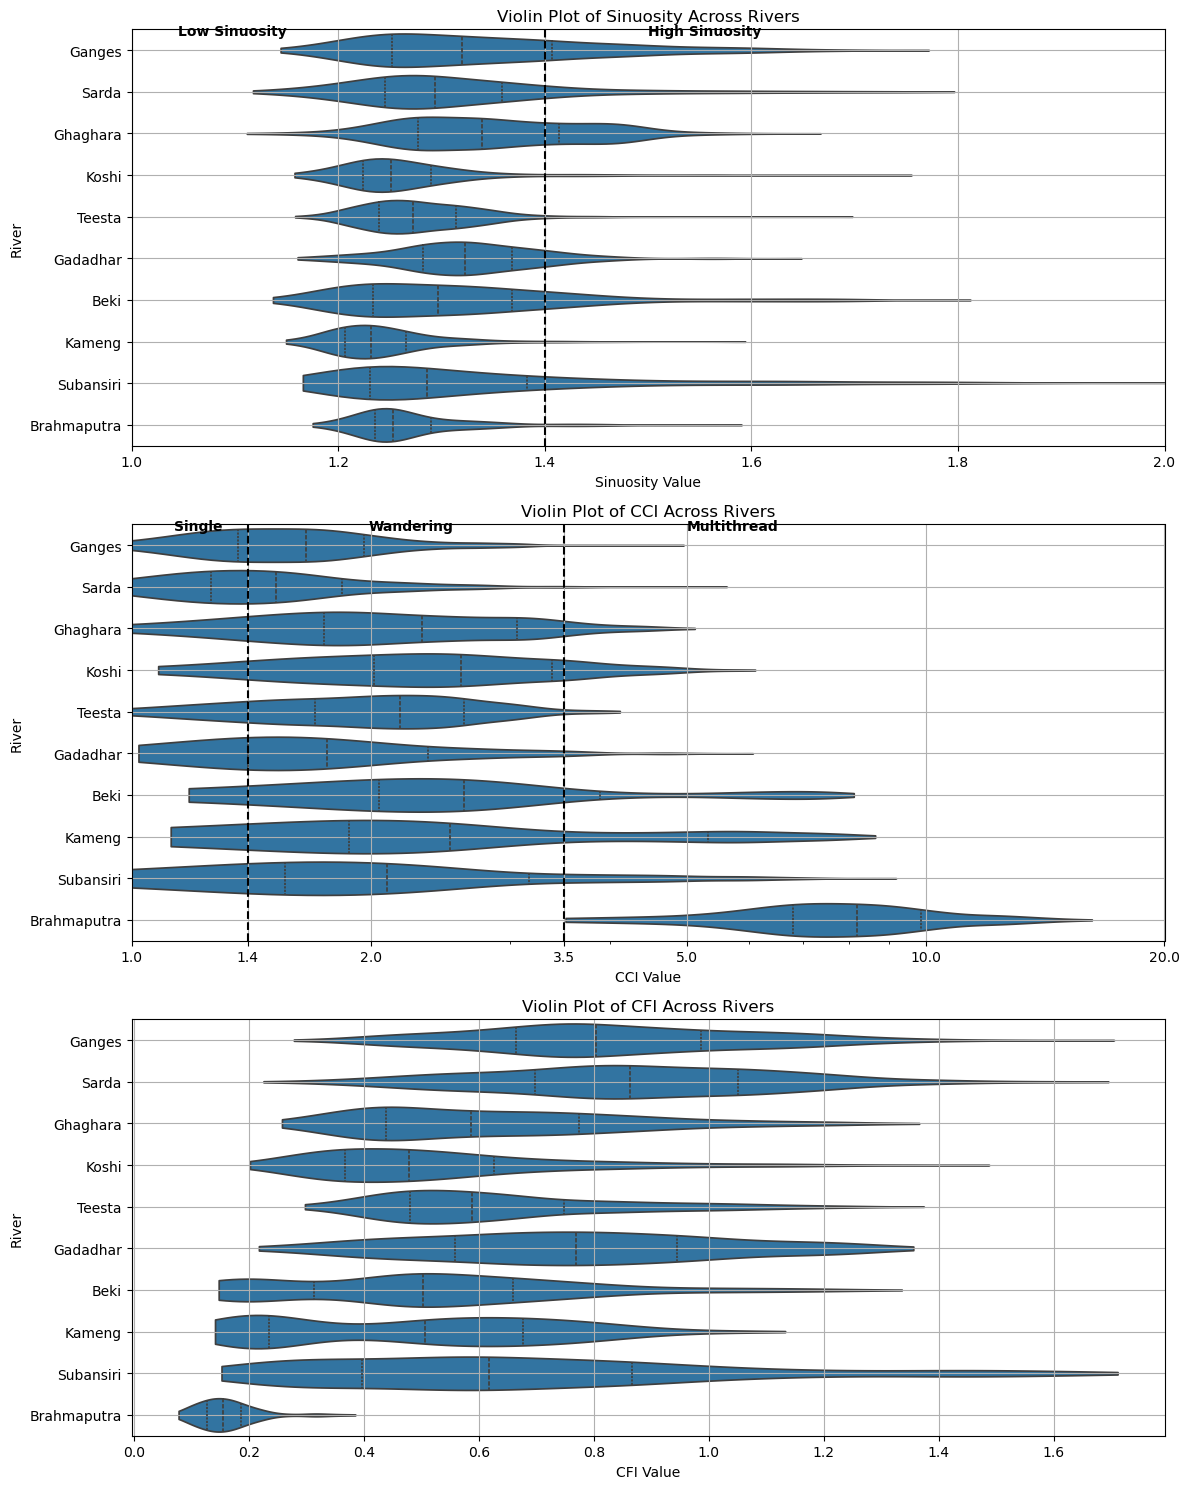

In [7]:
# Usage Example:
# Initialize the RiverSystem
Himalaya = RiverSystem()

# Load multiple rivers
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Ganges\Ganges_metrics.xlsx", "Ganges")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Sarda\Sarda_metrics.xlsx", "Sarda")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Ghaghara\Ghaghara_metrics.xlsx", "Ghaghara")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Koshi\Koshi_metrics.xlsx", "Koshi")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Teesta\Teesta_metrics.xlsx", "Teesta")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Gadadhar\Gadadhar_metrics.xlsx", "Gadadhar")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Beki\Beki_metrics.xlsx", "Beki")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Kameng\Kameng_metrics.xlsx", "Kameng")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Subansiri\Subansiri_metrics.xlsx", "Subansiri")
Himalaya.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Brahmaputra\Brahmaputra_metrics.xlsx", "Brahmaputra")


# Compare Sinuosity across all rivers for a specific year range and reach range
metrics = ['Sinuosity', 'CCI', 'CFI']
Himalaya.compare_metrics(metrics, year_range="All", reach_range="All", save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalaya_distribution.jpeg")
Himalaya.compare_metrics_violin(metrics, year_range="All", reach_range="All", save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalaya_violin.jpeg")
# Retrieve and work with a specific river
#koshi_river_data = river_system.get_river("Koshi")
#koshi_river_data.plot_histogram('CCI', year_range=(2000, 2005), reach_range=(2, 4))

In [ ]:
Himalaya.plot_metric_over_time_by_reach(metric='CFI', save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalaya_CFI_over_time_by_reach.pdf")

Comparison plot saved to C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\New_Guinea_distribution.jpeg


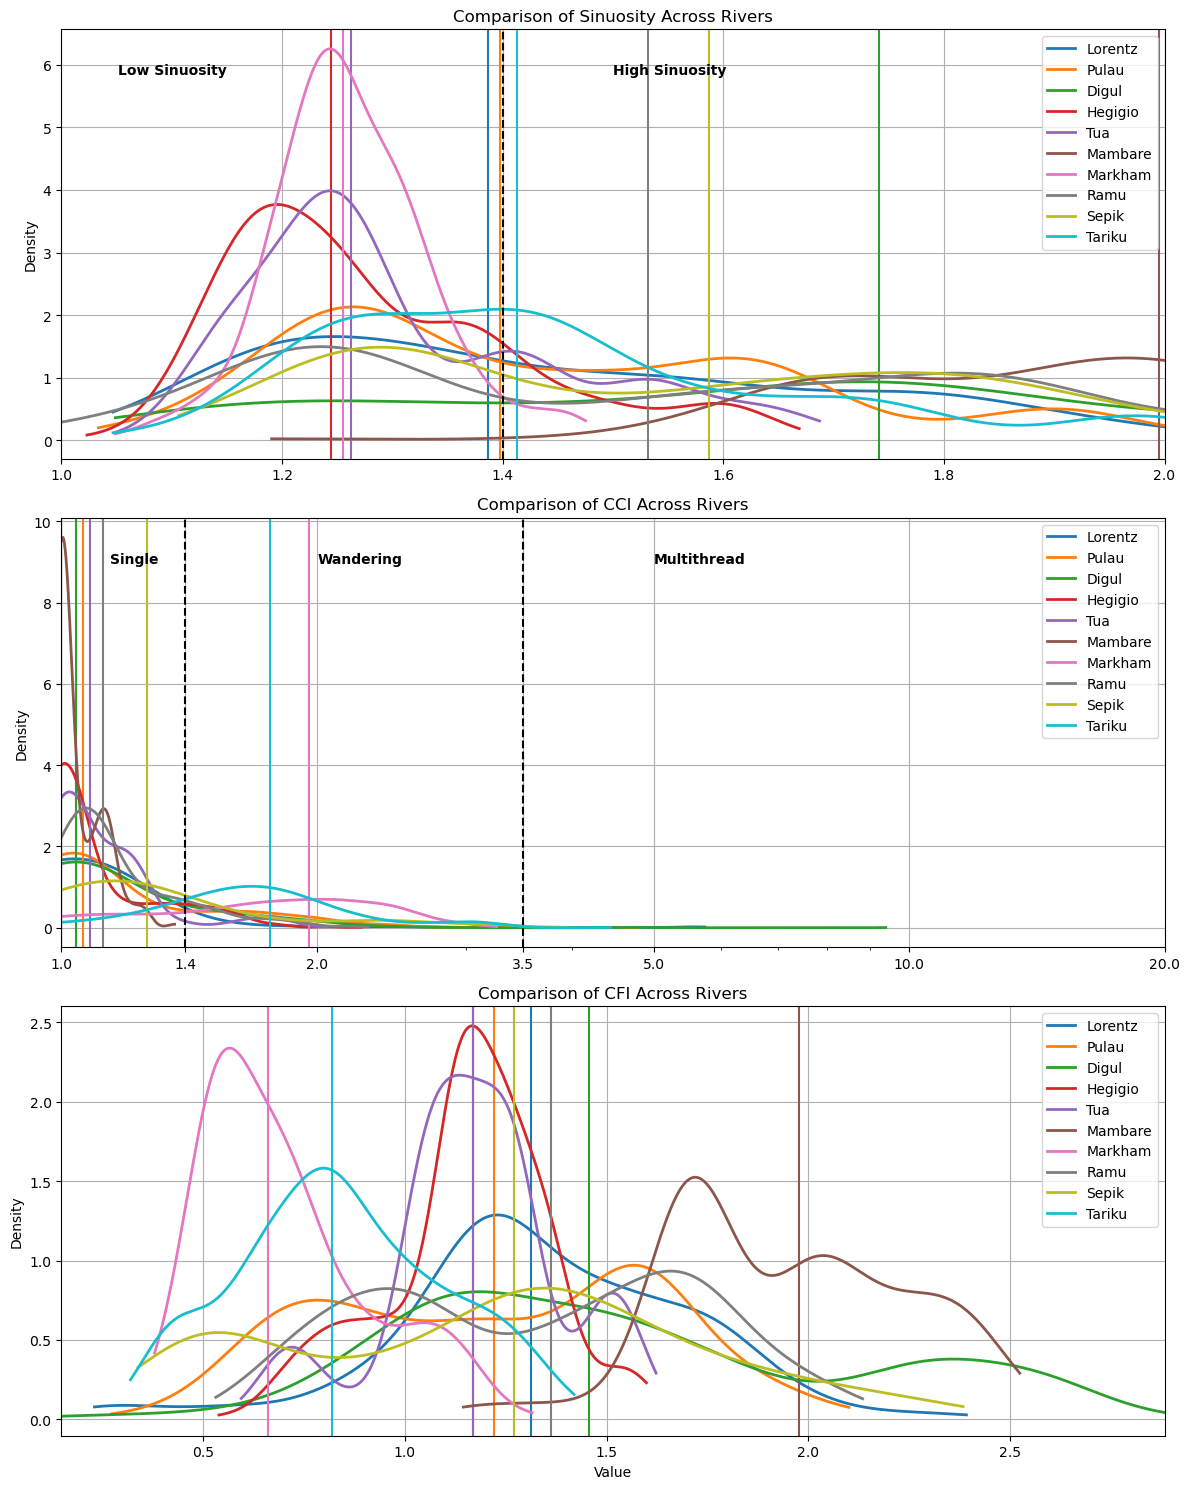

C:\Users\huckr\AppData\Local\Temp\ipykernel_9964\3972257554.py:183: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Metric', y='River', data=df, ax=ax, cut=0, scale='width', inner='quartile')
C:\Users\huckr\miniconda3\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\huckr\miniconda3\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\huckr\miniconda3\Lib\site-packages\seaborn\_base.py:949: FutureWarning

Violin plot comparison saved to C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\New_Guinea_violin.jpeg


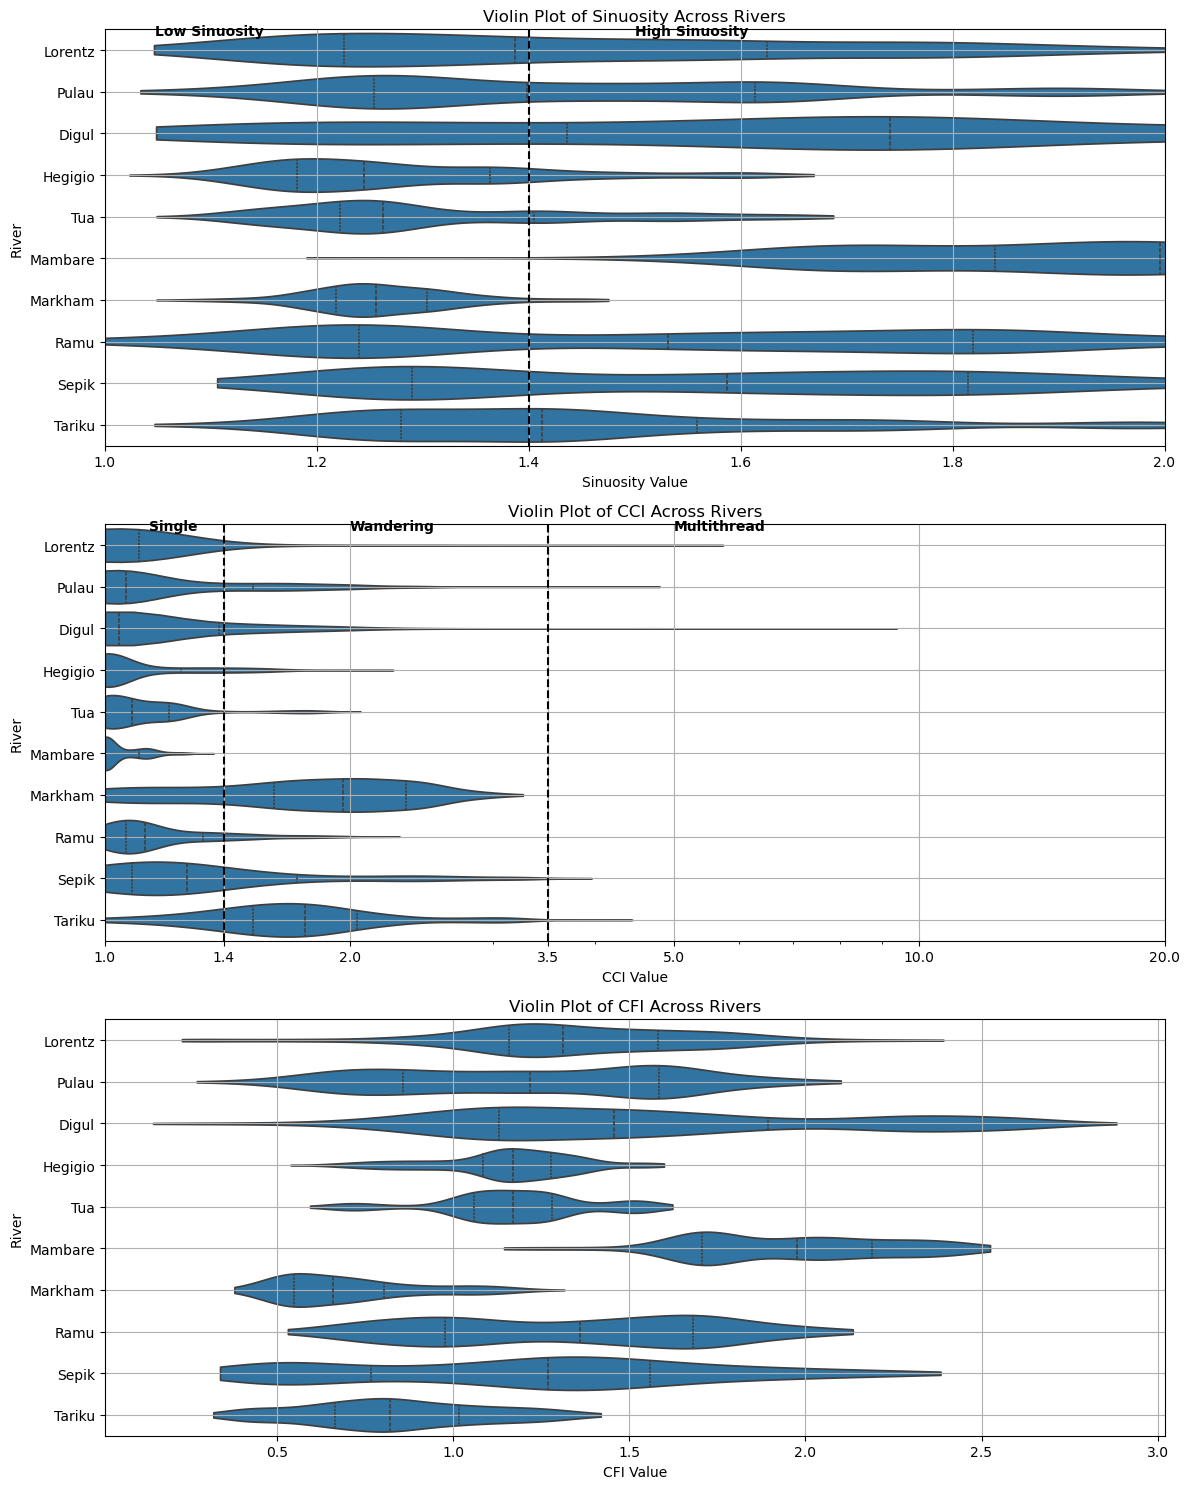

PDF saved as C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\New_Guinea_CFI_over_time_by_reach.pdf


In [8]:
# Usage Example:
# Initialize the RiverSystem
New_Guinea = RiverSystem()

# Load multiple rivers
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Lorentz\Lorentz_metrics.xlsx", "Lorentz")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Pulau\Pulau_metrics.xlsx", "Pulau")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Digul\Digul_metrics.xlsx", "Digul")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Hegigio\Hegigio_metrics.xlsx", "Hegigio")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Tua\Tua_metrics.xlsx", "Tua")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Mambare\Mambare_metrics.xlsx", "Mambare")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Markham\Markham_metrics.xlsx", "Markham")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Ramu\Ramu_metrics.xlsx", "Ramu")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Sepik\Sepik_metrics.xlsx", "Sepik")
New_Guinea.load_river(r"C:\Users\huckr\Desktop\UCSB\Dissertation\Data\RiverMapping\Channels\Tariku\Tariku_metrics.xlsx", "Tariku")


# Compare Sinuosity across all rivers for a specific year range and reach range
metrics = ['Sinuosity', 'CCI', 'CFI']
New_Guinea.compare_metrics(metrics, year_range="All", reach_range="All", save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\New_Guinea_distribution.jpeg")
New_Guinea.compare_metrics_violin(metrics, year_range="All", reach_range="All", save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\New_Guinea_violin.jpeg")
# Retrieve and work with a specific river
#koshi_river_data = river_system.get_river("Koshi")
#koshi_river_data.plot_histogram('CCI', year_range=(2000, 2005), reach_range=(2, 4))
New_Guinea.plot_metric_over_time_by_reach(metric='CFI', save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\New_Guinea_CFI_over_time_by_reach.pdf")

In [9]:
Himalaya.compare_two_systems_violin(New_Guinea, metrics, year_range="All", reach_range="All", save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalya_vs_NewGuinea.pdf")


AttributeError: 'RiverSystem' object has no attribute 'compare_two_systems_violin'

Scatter plot of temporal means saved to C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalya_vs_NewGuinea_temporal_mean.pdf


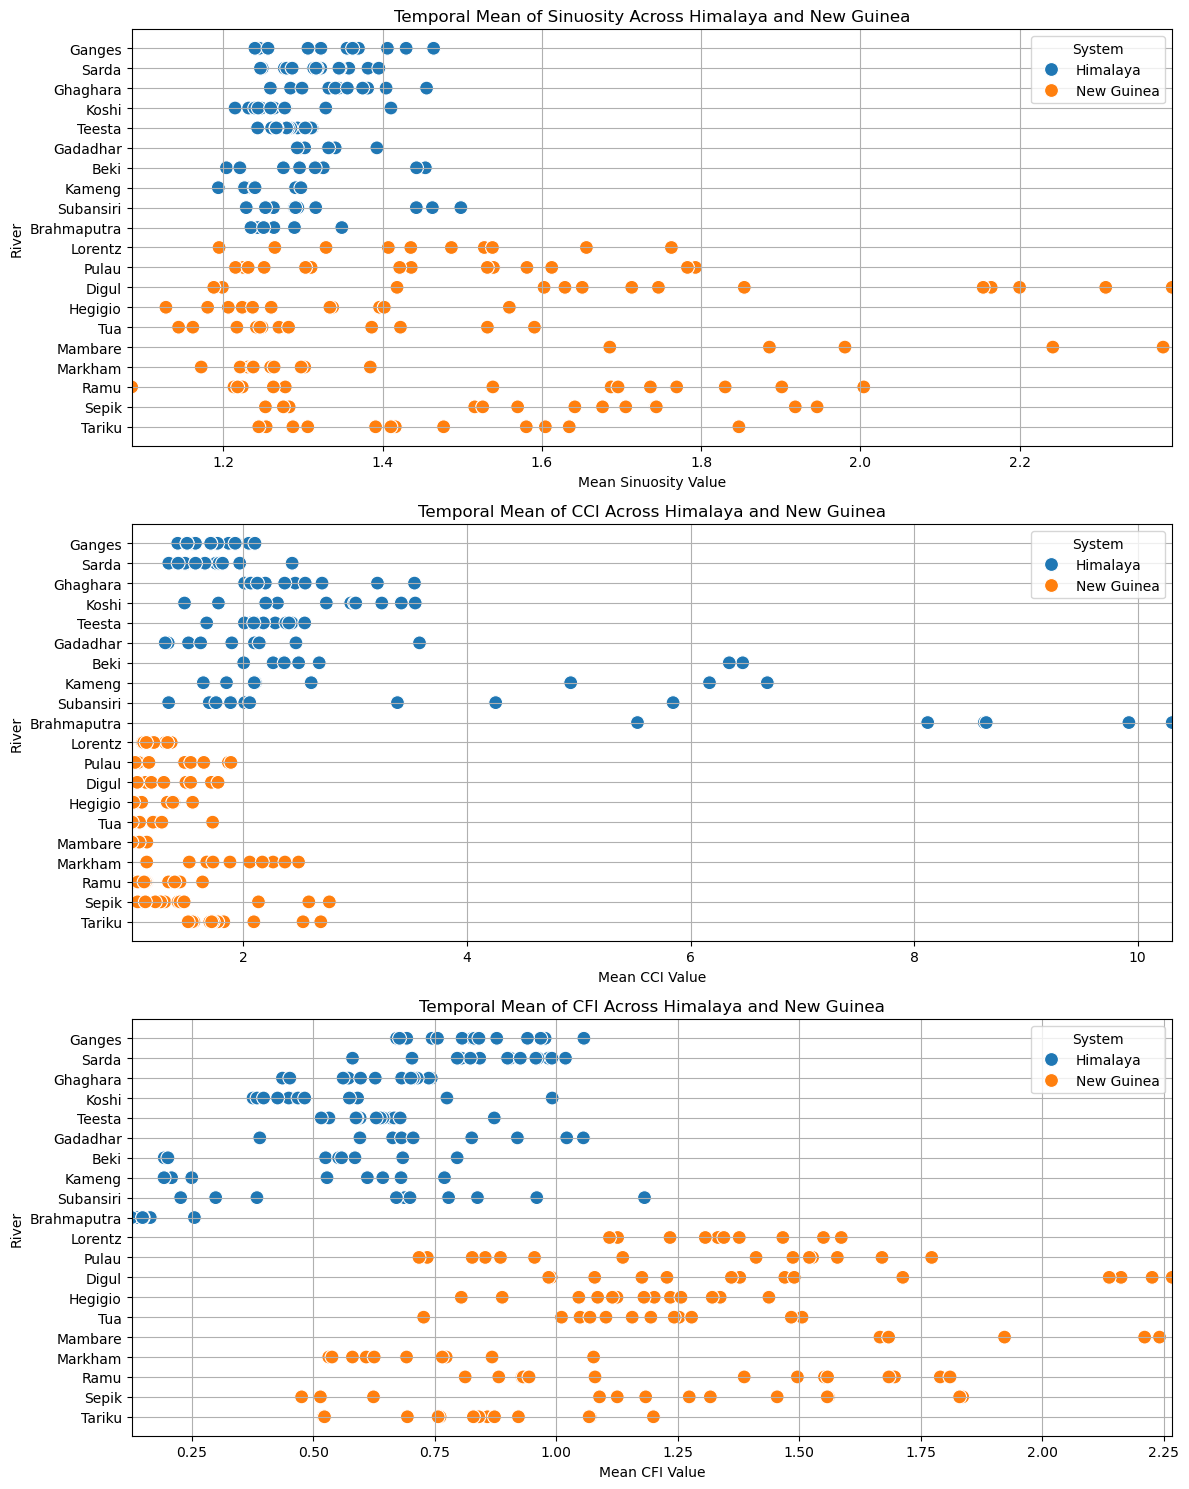

In [10]:
Himalaya.compare_two_systems_mean_dots(New_Guinea, metrics, system1_name="Himalaya", system2_name="New Guinea", year_range="All", reach_range="All", save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalya_vs_NewGuinea_temporal_mean.pdf")

C:\Users\huckr\AppData\Local\Temp\ipykernel_9964\3972257554.py:345: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Metric', y='River', hue='System', data=df, ax=ax, cut=0, scale='width', inner='quartile', split=True)
C:\Users\huckr\AppData\Local\Temp\ipykernel_9964\3972257554.py:345: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Metric', y='River', hue='System', data=df, ax=ax, cut=0, scale='width', inner='quartile', split=True)
C:\Users\huckr\AppData\Local\Temp\ipykernel_9964\3972257554.py:345: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Metric', y='River', hue='System', data=df, ax=ax, cut=0, scale='width', inner='quartile', split=True)


Violin plot of temporal means saved to C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalya_vs_NewGuinea_temporal_mean_violin.pdf


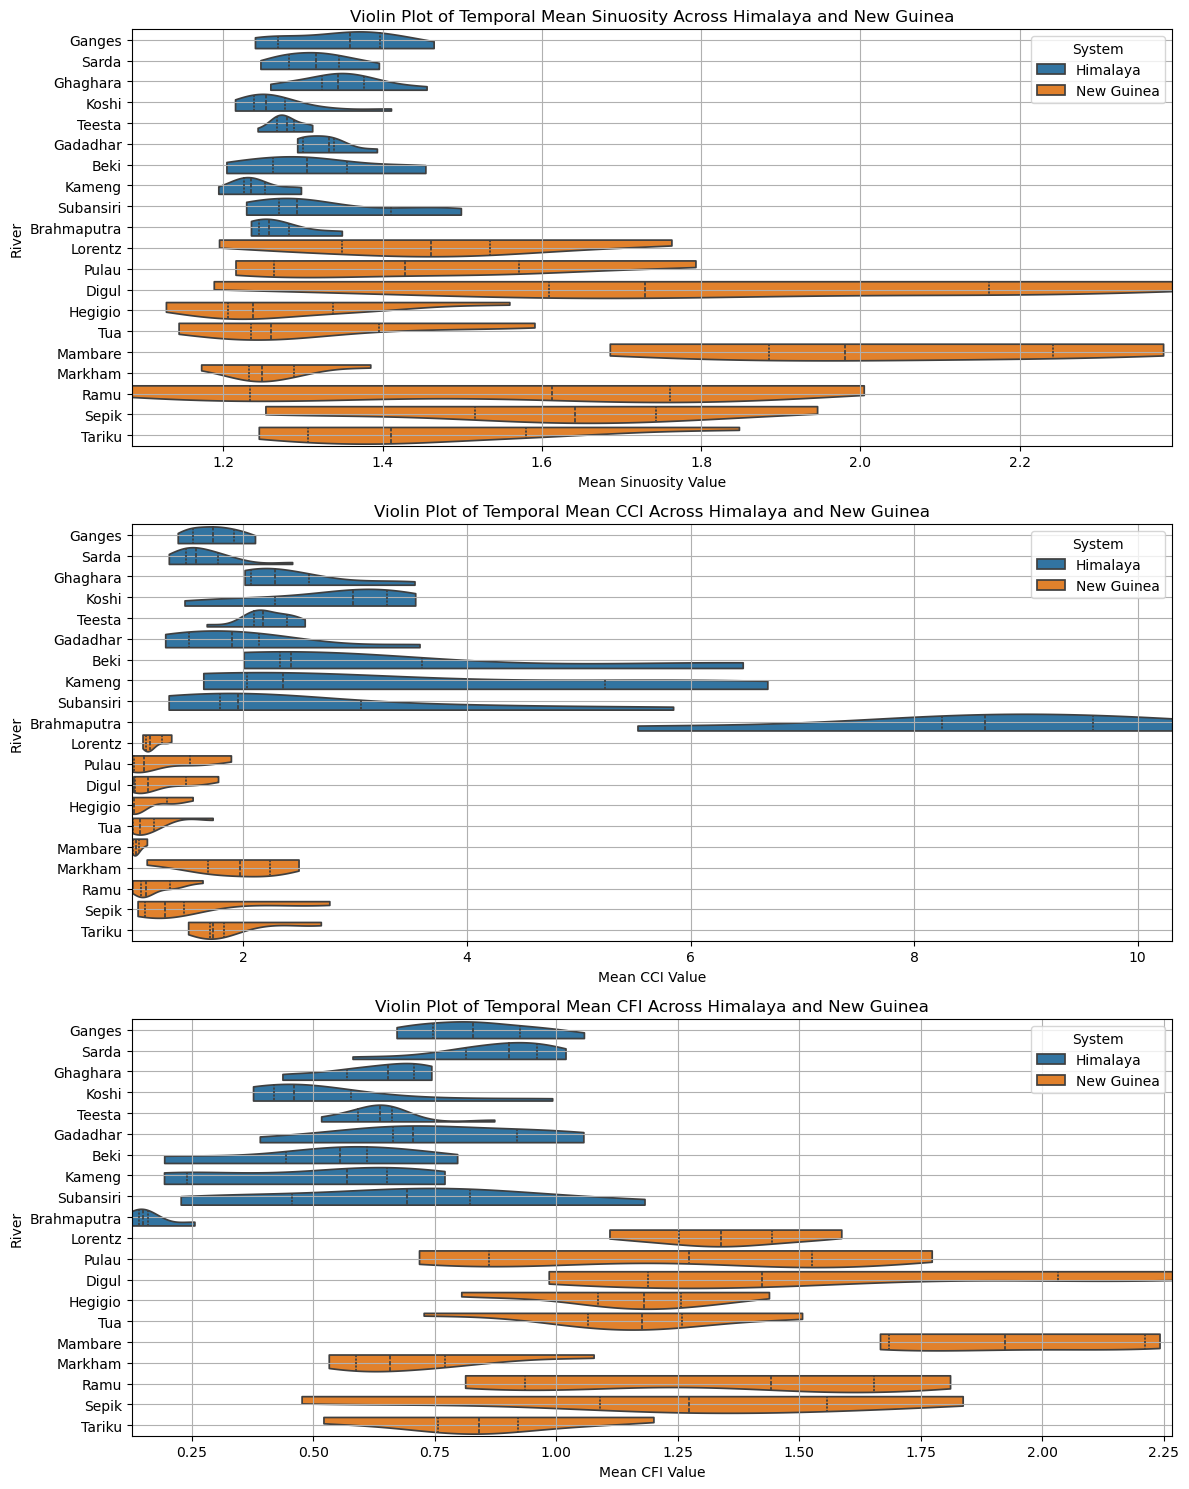

In [11]:
Himalaya.compare_two_systems_mean_violin(New_Guinea, metrics, system1_name="Himalaya", system2_name="New Guinea", year_range="All", reach_range="All", save_path=r"C:\Users\huckr\Desktop\UCSB\Dissertation\Analysis\CFI\Himalya_vs_NewGuinea_temporal_mean_violin.pdf")

In [ ]:
def test_within_system_differences(system, metric):
    """
    Performs a one-way ANOVA to test differences between rivers within the same system.
    
    Parameters:
    - system: The RiverSystem object
    - metric: The metric of interest (e.g., 'Sinuosity', 'CCI', 'CFI')
    
    Returns:
    - ANOVA table
    """
    # Initialize lists to store the data
    metric_values = []
    river_labels = []
    
    # Extract data from the system
    for river_name, river_data in system.rivers.items():
        metric_data = river_data.calculate_metric_data(metric)
        if metric_data.size > 0:
            # Add metric values
            metric_values.extend(metric_data)
            # Add river label (name of the river)
            river_labels.extend([river_name] * len(metric_data))
    
    # Create a DataFrame from the collected data
    df = pd.DataFrame({
        'Metric': metric_values,
        'River': river_labels
    })
    
    # Fit the one-way ANOVA model
    model = ols('Metric ~ C(River)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

In [ ]:
sin_anova_within_Himalaya = test_within_system_differences(Himalaya, 'Sinuosity')
sin_anova_within_NewGuinea = test_within_system_differences(New_Guinea, 'Sinuosity')

print("Sinuosity ANOVA within Himalaya:\n", sin_anova_within_Himalaya)
print("Sinuosity ANOVA within New Guinea:\n", sin_anova_within_NewGuinea)

cci_anova_within_Himalaya = test_within_system_differences(Himalaya, 'CCI')
cci_anova_within_NewGuinea = test_within_system_differences(New_Guinea, 'CCI')

print("CCI ANOVA within Himalaya:\n", cci_anova_within_Himalaya)
print("CCI ANOVA within New Guinea:\n", cci_anova_within_NewGuinea)

cfi_anova_within_Himalaya = test_within_system_differences(Himalaya, 'CFI')
cfi_anova_within_NewGuinea = test_within_system_differences(New_Guinea, 'CFI')

print("CFI ANOVA within Himalaya:\n", cfi_anova_within_Himalaya)
print("CFI ANOVA within New Guinea:\n", cfi_anova_within_NewGuinea)

In [ ]:
def test_between_system_differences(system_1, system_2, metric):
    """
    Performs a two-sample t-test to test differences between two systems.
    
    Parameters:
    - system_1: The first RiverSystem object
    - system_2: The second RiverSystem object
    - metric: The metric of interest (e.g., 'Sinuosity', 'CCI', 'CFI')
    
    Returns:
    - t-statistic and p-value
    """
    # Extract data from system_1
    metric_values_1 = []
    for river_name, river_data in system_1.rivers.items():
        metric_data = river_data.calculate_metric_data(metric)
        if metric_data.size > 0:
            metric_values_1.extend(metric_data)

    # Extract data from system_2
    metric_values_2 = []
    for river_name, river_data in system_2.rivers.items():
        metric_data = river_data.calculate_metric_data(metric)
        if metric_data.size > 0:
            metric_values_2.extend(metric_data)
    
    # Perform two-sample t-test
    t_stat, p_value = ttest_ind(metric_values_1, metric_values_2)
    return t_stat, p_value

In [ ]:
t_stat, p_value = test_between_system_differences(Himalaya, New_Guinea, 'Sinuosity')

print(f"T-test result for sinuosity between systems: t-statistic = {t_stat}, p-value = {p_value}")

In [ ]:
t_stat, p_value = test_between_system_differences(Himalaya, New_Guinea, 'CCI')

print(f"T-test result for CCI between systems: t-statistic = {t_stat}, p-value = {p_value}")

In [ ]:
t_stat, p_value = test_between_system_differences(Himalaya, New_Guinea, 'CFI')

print(f"T-test result for CFI between systems: t-statistic = {t_stat}, p-value = {p_value}")